In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import time
from pathlib import Path
import json
import logging
from rich import print

from daq_data.daq_data_resources import format_stream_images_response
from daq_data.daq_data_client import DaqDataClient
from daq_data.daq_data_visualizations import PanoImagePreviewer, PulseHeightDistribution


%load_ext autoreload
%autoreload 2

In [2]:
# load config and paths
cfg_dir = Path('daq_data/config')
daq_config_file = 'daq_config_grpc_simulate.json'
hp_io_config_simulate_file = 'hp_io_config_simulate.json'
with open(cfg_dir / hp_io_config_simulate_file, 'r') as f:
    hp_io_cfg = json.load(f)

with open(cfg_dir / daq_config_file, 'r') as f:
    daq_config = json.load(f)

In [3]:
# initialize the server
with DaqDataClient(daq_config, log_level=logging.INFO) as ddc:
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    if len(valid_daq_hosts) == 0:
        print(f"no valid daq hosts")
    service_summary = ddc.reflect_services([])
    print(service_summary)
    all_init_success = ddc.init_sim([])
    print(f"\t{all_init_success=}")


02:59:16 INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=331774;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=586940;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=374280;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=733367;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=219917;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=996148;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=927102;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=345794;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/empty.proto                                               

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=880346;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=89739;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: daq_data.proto                                                            

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=488376;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=800470;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/struct.proto                                              

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=693244;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=812058;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file:                                                                           
                  google/protobuf/timestamp.proto                                                                  

         INFO     [tid=8757206784] [_add_file_from_response()] Loading  ]8;id=849112;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py\proto_reflection_descriptor_database.py]8;;\:]8;id=639284;file:///Users/nico/anaconda3/envs/grpc-py39/lib/python3.9/site-packages/grpc_reflection/v1alpha/proto_reflection_descriptor_database.py#228\228]8;;\
                  descriptors from file: google/protobuf/empty.proto                                               

Reflecting services on 10.0.0.60:50051:
        found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']
        found DaqData service with name: daqdata.DaqData
        found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)
        found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)
        found: rpc Ping(Empty) returns (Empty)
Reflecting services on localhost:50051:
        found services: ['daqdata.DaqData', 'grpc.reflection.v1alpha.ServerReflection']
        found DaqData service with name: daqdata.DaqData
        found: rpc StreamImages(StreamImagesRequest) returns (stream StreamImagesResponse)
        found: rpc InitHpIo(InitHpIoRequest) returns (InitHpIoResponse)
        found: rpc Ping(Empty) returns (Empty)

         INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with         ]8;id=834453;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=741121;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#229\229]8;;\
                  {'data_dir': 'simulated_data_dir', 'update_interval_seconds': 0.5,                               
                  'force': True, 'simulate_daq': True, 'module_ids': []}                                           

02:59:19 INFO     [tid=8757206784] [init_hp_io()] host='10.0.0.60':                          ]8;id=907914;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=596193;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#233\233]8;;\
                  init_hp_io_response.success=True                                                                 

         INFO     [tid=8757206784] [init_hp_io()] Initializing the hp_io thread with         ]8;id=994063;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=498818;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#229\229]8;;\
                  {'data_dir': 'simulated_data_dir', 'update_interval_seconds': 0.5,                               
                  'force': True, 'simulate_daq': True, 'module_ids': []}                                           

02:59:21 INFO     [tid=8757206784] [init_hp_io()] host='localhost':                          ]8;id=465621;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py\daq_data_client.py]8;;\:]8;id=478457;file:///Users/nico/panoseti/panoseti_grpc/daq_data/daq_data_client.py#233\233]8;;\
                  init_hp_io_response.success=True                                                                 

all_init_success=True

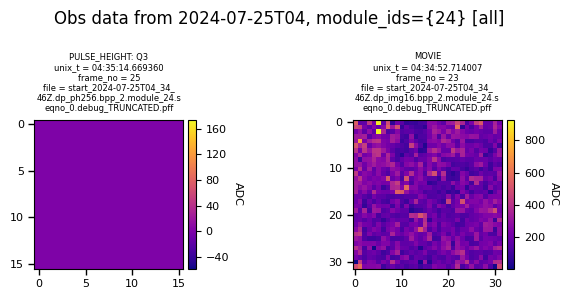

In [4]:
## Show PanoImagePreviewer: One DAQ node

# StreamImages config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=1.0

# Using the DaqData API
with DaqDataClient(daq_config) as ddc:
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], jupyter_notebook=True
    )

    # Get first valid daq node
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    host = list(valid_daq_hosts)[0] 
    
    # Call the StreamImages RPC on one valid DAQ node
    pano_image_stream = ddc.stream_images(
        host,
        stream_movie_data,
        stream_pulse_height_data,
        update_interval_seconds,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update plots
    for pano_image in pano_image_stream:
        previewer.update(pano_image)

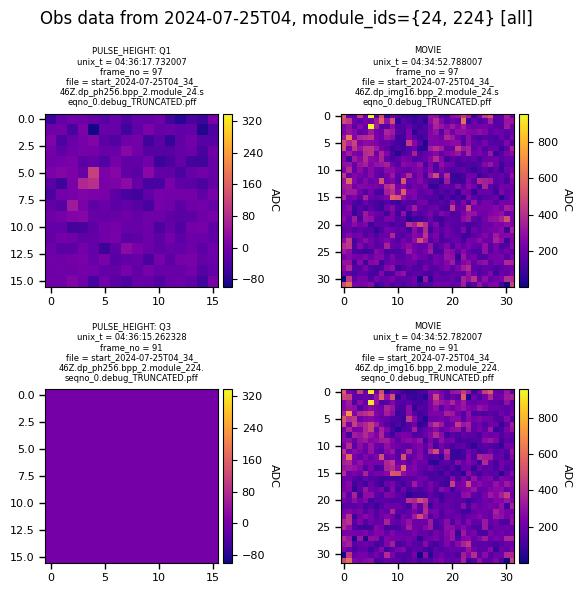

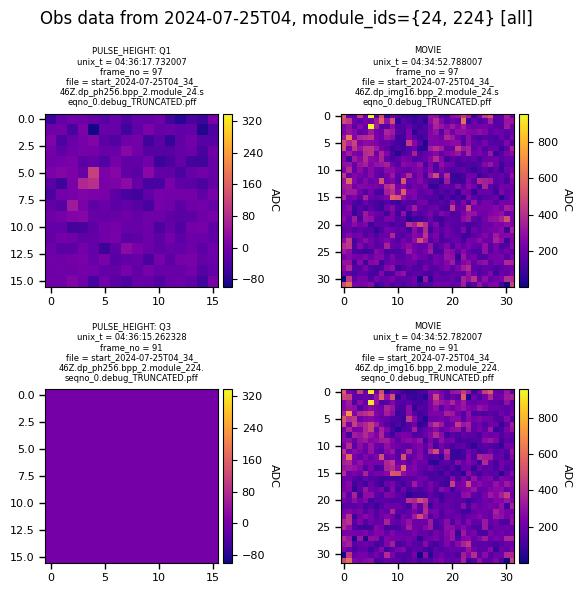

In [5]:
## Show PanoImagePreviewer: Multiple DAQ nodes

# StreamImages config 
stream_movie_data = True
stream_pulse_height_data = True
update_interval_seconds=2.0

# Using the DaqData API
with DaqDataClient(daq_config) as ddc:
    # Instantiate visualization class
    previewer = PanoImagePreviewer(
        stream_movie_data, stream_pulse_height_data, [], jupyter_notebook=True
    )
    # Call the StreamImages RPC on all valid DAQ nodes
    valid_daq_hosts = ddc.get_valid_daq_hosts()
    pano_image_stream = ddc.stream_images(
        valid_daq_hosts,
        stream_movie_data,
        stream_pulse_height_data,
        update_interval_seconds,
        wait_for_ready=True,
        parse_pano_images=True,
    )

    # Update plots
    for pano_image in pano_image_stream:
        previewer.update(pano_image)